# MovieLens
## Introduction
This project aims to compare different approaches to movie recommendation based on historical ratings of users.
Each model is tested in predicting the rating for a given user and movie pair. Available ratings are split into training and testing subsets. Models are scored based on accuracy of their predictions with respect to ratings in the training set.
I chose MovieLens dataset as I was also curious how the models scale with amount of data, both in their accuracy and computational requirements.

## Data set
The data set contains ratings of movies by users, in the form of records `(rating, movieId, userId)`.
The set is available in two sizes: `~100k` ratings and `~25m` ratings. These ratings are distributed among
`~42k` different movies and are given by `~260k` users. The records are transformed into sparse utility matrix with ratings as elements and user and movie ids as axes. The sparse storage is dictated by huge dimensions of the matrix coupled with sparsity of ratings (TODO % non-zero entries).

## Collaborative Filtering
Collaborative Filtering is a technique that attempts to predict unknown ratings by using known ratings of similar items.
It comes in two flavours:
1. `Item-item` - rating is predicted based on ratings of other similar movies rated by a given user.
2. `User-user` - rating is predicted based on ratings of a given movie rated by other similar users.

In this project I chose `item-item` approach for two reasons.
Firstly, according to literature it gives more stable results over time, as user tastes may change.
Secondly, the similarity matrix for movies is about 100 times smaller than for users (which would not fit in memory of my computer).
I tested two approaches to aggregating the users: Weighted Average and K-Most Similar Average.
Both of them use precomputed similarity matrix.
I chose cosine similarity as it is recommended by literature and can be precomputed using sparse matrix multiplication.
The result is stored as a dense matrix to facilitate faster access.

### Weighted Average
In this variant all ratings that have been found are aggregated by computing their average weighted by similarity.

\begin{align*}
    r_m^u =& \frac{\sum_{m' \in M_u} r_{m'}^u s_m^{m'}}{\sum_{m' \in M_u} s_m^{m'}} \\
    M_u =& \text{ set of movies rated by } u \\
    s_m^{m'} =& \text{ similarity of } m \text{ and } m'
\end{align*}


TODO:
- numerical stability with normalization
- large vs small data set w.r.t normalization

### K-Most Similar



### Singular Value Decomposition

This algorithm decomposes utility matrix of dimensions `MxU` into two rectangular matrices with dimensions `Mxk` and `kxU` where `k` is a parameter.
It does it in a way as to best approximate the original matrix.
Since 
This reduction of dimensionality extracts latent features of utlity matrix.
To predict of a movie by an user it suffices to multiply appropriate row of first matrix with a column of second.


TODO
- details of implementation for each Algorithms
- commentary on the results I got, why, etc.
- some conclusions
- maybe movie genre prediction


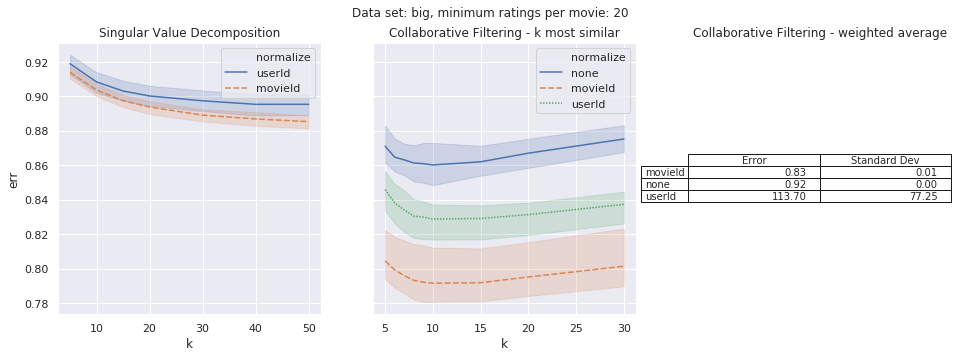

In [43]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()
%matplotlib inline

for size in ['big']:
    for min_ratings in [20]:
        svd = pd.read_csv(f"results/svd-{size}-{min_ratings}.csv")
        cf = pd.read_csv(f"results/cf-{size}-{min_ratings}.csv")
        knn = pd.read_csv(f"results/knn-{size}-{min_ratings}.csv")
        fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=[16, 5])
        fig.suptitle(f"Data set: {size}, minimum ratings per movie: {min_ratings}")
        axes[0].set_title("Singular Value Decomposition")
        sns.lineplot(ax=axes[0], data=svd, x='k', y='err', hue='normalize', style='normalize')
        axes[1].set_title("Collaborative Filtering - k most similar")
        sns.lineplot(ax=axes[1], data=knn, x='k', y='err', hue='normalize', style='normalize')
        cf = cf.groupby('normalize')
        fmt = lambda x: f"{x:.2f}"
        text = np.array([cf.mean().err.map(fmt), cf.std().err.map(fmt)]).T
        axes[2].axis('off')
        axes[2].set_title('Collaborative Filtering - weighted average')
        axes[2].table(
            cellText=text,
            rowLabels=cf.count().index,
            colLabels=['Error', 'Standard Dev'],
            loc='center'
        )

In [1]:
import numpy as np
import pandas as pd
from scipy.sparse import coo_matrix
import scipy.sparse.linalg as sa
from sklearn.model_selection import train_test_split
import seaborn as sns
from tqdm import tqdm_notebook, tqdm
sns.set()
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import util

def load_data(size='small', test_size=0.3, normalize='none'):
    ratings = util.read_files(size=size)[0]
    movie_counts = ratings.groupby('movieId').count()
#     good_movies = set(movie_counts[movie_counts['userId'] > 20].index)
#     good_users = set()
#     ratings = ratings[ratings.movieId.isin(good_movies)]
    indices = np.unique(ratings['movieId'].values, return_inverse=True)[1]
    ratings['movieId'] = indices.astype('int32')
    train, test = train_test_split(ratings, test_size=test_size)
    ok_movies = set(train['movieId'].values)
    ok_users = set(train['userId'].values)
    train, test = train.copy(), test[test['userId'].isin(ok_users) & test['movieId'].isin(ok_movies)].copy()
    if normalize == 'movieId' or normalize == 'userId':
        means = train.groupby(normalize)['rating'].mean()
        train['rating'] = train['rating'] - means.loc[train[normalize].array].values
        test['normalization_delta'] = means.loc[test[normalize].array].values
    else:
        test['normalization_delta'] = 0
    return train, test


# Item-item collaborative filtering
First precompute similarity matrix between all items
using cosine distance between rows of utility (`item x user`) matrix

Then predict unknown score for given `user` and `movie` by taking
weighted average of all ratings of this user

In [3]:
def calculate_item_item_similarity(ratings):
    """
    Calculate matrix of cosine distances between movies
    treated as vectors of ratings 
    """
    # Calculate the dot-products of ratings for all movies
    # Use sparse matrix for calculation to accomodate large data-set (~260k users, ~53k movies)
    # Storing results as dense matrix, allows us to use in-place operations
    # and provides faster indexing
    ii_similarity = coo_matrix(
        (ratings['rating'], (ratings['movieId'], ratings['userId']))
        ).tocsr()
    ii_similarity = ii_similarity.dot(ii_similarity.transpose()).toarray()
    
    d = 1 / np.sqrt(ii_similarity.diagonal())
    ii_similarity *= d.reshape((-1, 1))
    ii_similarity *= d.reshape((1, -1))
    return ii_similarity

In [4]:
def predict(user, movie, ii_similarity, ratings, user_ratings):
    """
    Predict rating of movie by user by calculating weighted average
    of ratings given by this user to other movies
    """
    other = ratings.iloc[user_ratings[user]]
    similarities = ii_similarity[movie, other['movieId']]
    tmp = similarities * other['rating']
    tmp = np.sum(tmp) / similarities.sum()
    return tmp

Asses rating prediction by calculating RMSE (Root Mean Square Error)

In [6]:
err_ii = []

cases = [(it, norm) for it in range(10) for norm in ['none', 'movieId', 'userId']]

for it, normalize in tqdm(cases):
    train, test = load_data(test_size=0.1, normalize=normalize)
    ii_similarity = calculate_item_item_similarity(train)
    user_ratings = train.groupby('userId').indices
    s = 0
    num_samples = len(test.index)
    for r in test.itertuples():
        p = r.normalization_delta + predict(r.userId, r.movieId, ii_similarity, train, user_ratings)
        s += np.float64((p - r.rating) ** 2)
    s /= num_samples
    s = np.sqrt(s)
    err_ii.append({ 'normalize': normalize, 'err': s })

err_ii = pd.DataFrame(err_ii)

100%|██████████| 30/30 [03:46<00:00,  7.55s/it]


In [8]:
err_ii = pd.DataFrame(err_ii)
print(f'Item-item CF error')
err_ii.groupby('normalize').mean()

Item-item CF error


,err
normalize,
movieId,3.501687
none,0.890116
userId,191.200408


# K-nearest neighbours
Find k most similar movies rated by a given user
and use average of their ratings.

In [4]:
def predict_knn(user, movie, k, ii_similarity, ratings, user_ratings):
    """
    Predict rating of movie by user by calculating average
    of ratings given by this user to k most similar movies
    """
    other = ratings.iloc[user_ratings[user]].copy()
    other['sim'] = ii_similarity[movie, other['movieId']]
    k = min(k, len(other.index))
    tmp = other.sort_values(by='sim', ascending=False).head(k)['rating'].mean()
    return tmp

In [6]:
err_knn = []
cases = [(it, norm) for it in range(3) for norm in ['none', 'movieId', 'userId']]

for it, normalize in tqdm(cases):
    train, test = load_data(test_size=0.01, normalize=normalize)
    ii_similarity = calculate_item_item_similarity(train)
    user_ratings = train.groupby('userId').indices
    for k in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 15, 20, 25, 30]:
        s = 0
        num_samples = len(test.index)
        for r in test.itertuples():
            p = r.normalization_delta + predict_knn(
                r.userId, r.movieId, k, ii_similarity, train, user_ratings)
            s += np.float64((p - r.rating) ** 2)
        s /= num_samples
        s = np.sqrt(s)
        err_knn.append({ 'k': k, 'err': s, 'it': it, 'normalize': normalize })

err_knn = pd.DataFrame(err_knn)

 11%|█         | 1/9 [00:18<02:25, 18.21s/it]

Done iter 0


 22%|██▏       | 2/9 [00:36<02:07, 18.21s/it]

Done iter 0


 33%|███▎      | 3/9 [00:54<01:49, 18.24s/it]

Done iter 0


 44%|████▍     | 4/9 [01:13<01:31, 18.31s/it]

Done iter 1


 56%|█████▌    | 5/9 [01:32<01:14, 18.52s/it]

Done iter 1


 67%|██████▋   | 6/9 [01:52<00:57, 19.07s/it]

Done iter 1


 78%|███████▊  | 7/9 [02:11<00:38, 19.09s/it]

Done iter 2


 89%|████████▉ | 8/9 [02:31<00:19, 19.25s/it]

Done iter 2


100%|██████████| 9/9 [02:50<00:00, 18.90s/it]

Done iter 2


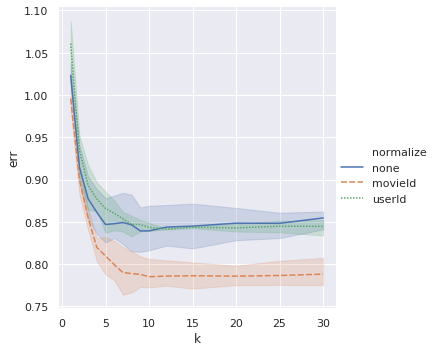

In [7]:
data = err_knn # [err_knn['norm_by'] != 'userId']
sns.relplot(data=data, x='k', y='err', kind='line', hue='normalize', style='normalize')

# Singular Value Decomposition
Factorize the utility matrix using SVD. This allows us to extract latent features
and reduce the dimensionality of the problem. Predict the rating by reconstructing
entries of utility matrix.

Entries in each row are normalized by average rating for a given user.
This allows us to keep the matrix sparse.

In [5]:
err_svd = []
cases = [(it, norm) for it in range(10) for norm in ['userId', 'movieId']]

for it, normalize in tqdm(cases):
    train, test = load_data(size='big', test_size=10000, normalize=normalize)
    utility = coo_matrix(
        (train['rating'], (train['userId'], train['movieId']))
        ).tocsr()
    for k in [20, 30, 40, 50]:
        u, s, vt = sa.svds(utility, k=k)
        u = u @ np.diag(s)
        s = 0
        num_samples = len(test.index)
        for r in test.itertuples():
            p = r.normalization_delta + u[r.userId, :] @ vt[:, r.movieId]
            s += np.float64((p - r.rating) ** 2)
        s /= num_samples
        s = np.sqrt(s)
        err_svd.append({ 'k': k, 'err': s, 'it': it, 'normalize': normalize })
    # print(f'Done iter {it}')

err_svd = pd.DataFrame(err_svd)

100%|██████████| 20/20 [20:06<00:00, 60.30s/it]


,k,err,it,normalize
0,20,0.892843,0,userId
1,30,0.890189,0,userId
2,40,0.887584,0,userId
3,50,0.887567,0,userId
4,20,0.889788,0,movieId
...,...,...,...,...
75,50,0.874053,9,userId
76,20,0.901518,9,movieId
77,30,0.894763,9,movieId
78,40,0.894300,9,movieId


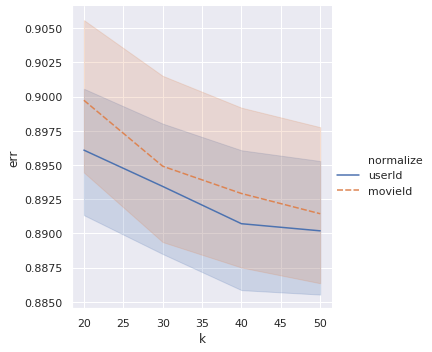

In [6]:
data = err_svd[err_svd['normalize'] != 'none']
sns.relplot(data=data, x='k', y='err', kind='line', hue='normalize', style='normalize')
data

In [62]:
train, test = load_data()
ratings, means = normalize(train, by='userId')
ratings

,userId,movieId,rating
96788,603,652,0.548828
73217,474,151,1.466797
26361,182,421,0.960938
27083,183,306,0.087891
57685,380,1017,1.037109
...,...,...,...
60413,391,25,0.398438
23399,160,405,-1.863281
53198,352,23,1.103516
12799,82,403,0.541016
